In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, glob
import soundfile as sf # <-- read audio
from scipy.spatial import ConvexHull
import sofa # <-- read SOFA HRTFs
import librosa # <-- resample function
from scipy import signal # <-- fast convolution function
from IPython.display import Audio # <-- Audio listening in notebook
import copy


## HRTF Preparation

In [2]:
#load original HRTF files
source_dir = 'Samples 48k/*.wav'
hrtf_dir_MIT = 'HRTFs/*.wav'

_SOURCES = glob.glob(source_dir)
_MIT = glob.glob(hrtf_dir_MIT)

_SOURCES.sort()
_MIT.sort()

# Run this for a rundown of HRTF sets available and 
# their index to use in a function
print('List of HRTF files:')
for s in range(len(_MIT)):
    print('\033[1m' + str(s) +'. ' + '\033[0m' + _MIT[s][5:])  
    

List of HRTF files:
0. /H-30e000a.wav
1. /H-30e030a.wav
2. /H-30e060a.wav
3. /H-30e090a.wav
4. /H-30e120a.wav
5. /H-30e150a.wav
6. /H-30e180a.wav
7. /H0e015a.wav
8. /H0e045a.wav
9. /H0e075a.wav
10. /H0e105a.wav
11. /H0e135a.wav
12. /H0e165a.wav
13. /H30e000a.wav
14. /H30e030a.wav
15. /H30e060a.wav
16. /H30e090a.wav
17. /H30e120a.wav
18. /H30e150a.wav
19. /H30e180a.wav
20. /H90e000a.wav


In [3]:
# Get HRTF in the corresponding speaker direction
# The order of my speaker array is: 12 in ele-30, 12 in ele0, 12 in ele30, 1 at top, 1 at bottom
HRIRs_array = []

for i in range(38):
    if i < 7:
        idx_MIT = i
    elif i < 12:
        idx_MIT = 12 - i
    elif i < 18:
        idx_MIT = i - 5
    elif i < 24:
        idx_MIT = 30 - i
    elif i < 31:
        idx_MIT = i - 11
    elif i < 36:
        idx_MIT = 49 - i
    elif i < 38:
        idx_MIT = 20
        
    
    [HRIR,fs_H] = sf.read(_MIT[idx_MIT])
    if (0<i<6) or (11<i<18) or (24<i<30):
        HRIR_mirror = copy.deepcopy(HRIR)
        HRIR_mirror[:, 0] = HRIR[:, 1]
        HRIR_mirror[:, 1] = HRIR[:, 0]
        HRIR = HRIR_mirror
        
    HRIRs_array.append(HRIR)
    print(i)
    print('Using HRTF: ' + _MIT[idx_MIT])
    print('Sample rate = ' + str(fs_H))
    print('Data dimensions: ',HRIR.shape)
    print('')

0
Using HRTF: HRTFs/H-30e000a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

1
Using HRTF: HRTFs/H-30e030a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

2
Using HRTF: HRTFs/H-30e060a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

3
Using HRTF: HRTFs/H-30e090a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

4
Using HRTF: HRTFs/H-30e120a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

5
Using HRTF: HRTFs/H-30e150a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

6
Using HRTF: HRTFs/H-30e180a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

7
Using HRTF: HRTFs/H-30e150a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

8
Using HRTF: HRTFs/H-30e120a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

9
Using HRTF: HRTFs/H-30e090a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

10
Using HRTF: HRTFs/H-30e060a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

11
Using HRTF: HRTFs/H-30e030a.wav
Sample rate = 44100
Data dimensions:  (128, 2)

12
Using HRTF:

In [4]:
#Play HFTF for checking
for i in range(38):
    print('HRTF' + str(i) + ':')
    display(Audio(HRIRs_array[i].transpose(),rate=fs_H))

HRTF0:


HRTF1:


HRTF2:


HRTF3:


HRTF4:


HRTF5:


HRTF6:


HRTF7:


HRTF8:


HRTF9:


HRTF10:


HRTF11:


HRTF12:


HRTF13:


HRTF14:


HRTF15:


HRTF16:


HRTF17:


HRTF18:


HRTF19:


HRTF20:


HRTF21:


HRTF22:


HRTF23:


HRTF24:


HRTF25:


HRTF26:


HRTF27:


HRTF28:


HRTF29:


HRTF30:


HRTF31:


HRTF32:


HRTF33:


HRTF34:


HRTF35:


HRTF36:


HRTF37:


## Setup corressponding speaker array

In [5]:
#set loud speaker array
ls_az = np.concatenate((np.arange(0, 360, 30),np.arange(15, 360, 30), np.arange(0, 360, 30), np.zeros(2)))
print('Azimuth cordinates for the speaker array:')
print(ls_az)
print('Dimensions for azimuth cordinates:')
print(ls_az.shape)
print('')
ls_ele = np.concatenate((np.ones(12)* -30, np.zeros(12), np.ones(12)* 30, np.array([90, -90])))
print('Elevation cordinates for the speaker array:')
print(ls_ele)
print('Dimensions for elevation cordinates:')
print(ls_ele.shape)

Azimuth cordinates for the speaker array:
[  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330.  15.  45.
  75. 105. 135. 165. 195. 225. 255. 285. 315. 345.   0.  30.  60.  90.
 120. 150. 180. 210. 240. 270. 300. 330.   0.   0.]
Dimensions for azimuth cordinates:
(38,)

Elevation cordinates for the speaker array:
[-30. -30. -30. -30. -30. -30. -30. -30. -30. -30. -30. -30.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  30.  30.  30.  30.
  30.  30.  30.  30.  30.  30.  30.  30.  90. -90.]
Dimensions for elevation cordinates:
(38,)


In [6]:
#angular to cartesian codinates
def ang_to_cart(azi, ele):
    ele_rad = ele / 360 * 2 * np.pi
    azi_rad = azi / 360 * 2 * np.pi
    x = np.cos(ele_rad) * np.cos(azi_rad)
    y = np.cos(ele_rad) * np.sin(azi_rad)
    z = np.sin(ele_rad)
    return np.array([x, y, z])

In [7]:
#get loud speakers vecter in cart
ls_vector = np.zeros((3, len(ls_az)))
for i in range(len(ls_az)):
    ls_vector[:, i] = ang_to_cart(ls_az[i], ls_ele[i])
print(ls_vector)

[[ 8.66025404e-01  7.50000000e-01  4.33012702e-01  5.30287619e-17
  -4.33012702e-01 -7.50000000e-01 -8.66025404e-01 -7.50000000e-01
  -4.33012702e-01 -1.59086286e-16  4.33012702e-01  7.50000000e-01
   9.65925826e-01  7.07106781e-01  2.58819045e-01 -2.58819045e-01
  -7.07106781e-01 -9.65925826e-01 -9.65925826e-01 -7.07106781e-01
  -2.58819045e-01  2.58819045e-01  7.07106781e-01  9.65925826e-01
   8.66025404e-01  7.50000000e-01  4.33012702e-01  5.30287619e-17
  -4.33012702e-01 -7.50000000e-01 -8.66025404e-01 -7.50000000e-01
  -4.33012702e-01 -1.59086286e-16  4.33012702e-01  7.50000000e-01
   6.12323400e-17  6.12323400e-17]
 [ 0.00000000e+00  4.33012702e-01  7.50000000e-01  8.66025404e-01
   7.50000000e-01  4.33012702e-01  1.06057524e-16 -4.33012702e-01
  -7.50000000e-01 -8.66025404e-01 -7.50000000e-01 -4.33012702e-01
   2.58819045e-01  7.07106781e-01  9.65925826e-01  9.65925826e-01
   7.07106781e-01  2.58819045e-01 -2.58819045e-01 -7.07106781e-01
  -9.65925826e-01 -9.65925826e-01 -7.0710

In [8]:
#Get all triangles around the sphere, and store the speaker's indexes into an array
triangles = ConvexHull(ls_vector.T).simplices
print(triangles)
print(triangles.shape)

[[ 7  8 37]
 [ 0 11 37]
 [ 9  8 37]
 [31 32 36]
 [19  7 18]
 [19  7  8]
 [19 31 18]
 [19 31 32]
 [23  0 12]
 [23  0 11]
 [33 32 36]
 [10  9 21]
 [10 11 37]
 [10  9 37]
 [24 35 36]
 [24 25 36]
 [24 25 12]
 [24 23 35]
 [24 23 12]
 [26 25 36]
 [34 33 21]
 [34 35 36]
 [34 33 36]
 [20 19 32]
 [20 33 32]
 [20 33 21]
 [20  9  8]
 [20  9 21]
 [20 19  8]
 [ 6  7 37]
 [ 6  5 37]
 [ 6  7 18]
 [ 1  0 37]
 [ 1  2 37]
 [ 1  0 12]
 [ 4  5 37]
 [22 23 11]
 [22 10 11]
 [22 10 21]
 [22 23 35]
 [22 34 35]
 [22 34 21]
 [30 31 36]
 [30 29 36]
 [30 31 18]
 [17  6 18]
 [17  6  5]
 [17 30 18]
 [17 30 29]
 [28 29 36]
 [16 17 29]
 [16 28 29]
 [16 28 15]
 [16  4  5]
 [16  4 15]
 [16 17  5]
 [ 3  4 15]
 [ 3 14  2]
 [ 3 14 15]
 [ 3  2 37]
 [ 3  4 37]
 [27 28 15]
 [27 14 15]
 [27 14 26]
 [27 26 36]
 [27 28 36]
 [13 25 12]
 [13 26 25]
 [13 14 26]
 [13 14  2]
 [13  1 12]
 [13  1  2]]
(72, 3)


## Load audio source and resample

In [27]:
# Load an audio source
source_idx = 2
print('Source is: ' + _SOURCES[source_idx])
[sig, fs_s] = sf.read(_SOURCES[source_idx])
print('Sample rate: ',fs_s)
print('Data dimensions: ',sig.shape)

# Turn a stereo source into mono
if sig.shape[1]>1:
    sig_mono = np.mean(sig,axis=1)
else:
    sig_mono = sig

print('New data dimensions: ',sig_mono.shape)

# Listen to the mono version
Audio(sig_mono,rate=fs_s)

#get spatial information of panning

Source is: Samples 48k/01 Light Entertainment Audience, Quiet, Expectant-48k.wav
Sample rate:  48000
Data dimensions:  (444000, 2)
New data dimensions:  (444000,)


In [11]:
# Sample rates are different - resample to match
def fs_resample(s1,f1,s2,f2):
    if f1 != f2:
        if f2 < f1:
            s2 = librosa.core.resample(s2.transpose(),f2,f1)
            s2 = s2.transpose()
        else:
            s1 = librosa.core.resample(s1.transpose(),f1,f2)
            s1 = s1.transpose()
    fmax = max([f1,f2])
    f1 = fmax
    f2 = fmax
    print('Resampled at: ', fmax,'Hz')
    return s1, f1, s2, f2

In [12]:
# Resample signal or HRIR to match sample rate
sr_s = fs_s #store sourse sample rate
sr_H = fs_H #store HRIR sample rate
for i in range(len(HRIRs_array)):
    # Use function
    [sig_mono, fs_s, HRIRs_array[i], fs_H] = fs_resample(sig_mono,fs_s, HRIRs_array[i],fs_H)
    # Reset fs_s & fs_H
    fs_s = sr_s
    fs_H = sr_H
    print('sig dimensions: ',sig_mono.shape)
    print('hrir dimensions: ',HRIRs_array[i].shape)
    print(' ')

Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions:  (576000,)
hrir dimensions:  (140, 2)
 
Resampled at:  48000 Hz
sig dimensions: 

## Find active VBAP base and perform convolution

In [13]:
#calculate gain for triangle 
def calc_gain(base, p_cart):
    gains = np.linalg.solve(base, p_cart)
    return gains

In [14]:
def normalize(gains, norm):
    return gains * np.sqrt(norm / np.sum(gains ** 2))

In [15]:
#find active speaker triangle
def find_active_triangles(p_cart, ls_vectors, triangles):
    base = np.zeros((3,3))
    for i in range(len(triangles)):
        ls_index = triangles[i]
        for j in range(3):
            base[:, j] = ls_vector[:, ls_index[j]]
    
        gains = calc_gain(base, p_cart)
        if np.min(gains)>=0:
            gains = normalize(gains, 1)
            return gains, ls_index

In [16]:
#convolve HRIR
def convolution(sig_mono, HRIRs_array, ls_index, gains):
    # Convolve --> Frequency domain is faster
    L_out = np.zeros(len(sig_mono)+ HRIRs_array[0].shape[0]-1)
    R_out = np.zeros(len(sig_mono)+ HRIRs_array[0].shape[0]-1)
    
    for i in range(3):
        # spatialized source for Left channel
        HRIR_index = ls_index[i]
        L_out = L_out + signal.fftconvolve(sig_mono,HRIRs_array[HRIR_index][:,0].T) * gains[i]
        # spatialized source for Right channel
        R_out = R_out + signal.fftconvolve(sig_mono,HRIRs_array[HRIR_index][:,1].T) * gains[i]


    Bin_Mix = np.vstack([L_out,R_out]).transpose()
    Bin_Mix = Bin_Mix/np.max(np.abs(Bin_Mix))
    # print('Data Dimensions: ', Bin_Mix.shape) 
    return Bin_Mix

## Get user input and perform VBAP panning

In [82]:
# Load an audio source
source_idx = 22
print('Source is: ' + _SOURCES[source_idx])
[sig, fs_s] = sf.read(_SOURCES[source_idx])
print('Sample rate: ',fs_s)
print('Data dimensions: ',sig.shape)

# Turn a stereo source into mono
if sig.shape[1]>1:
    sig_mono = np.mean(sig,axis=1)
else:
    sig_mono = sig

print('New data dimensions: ',sig_mono.shape)

# Listen to the mono version
Audio(sig_mono,rate=fs_s)

#get spatial information of panning

Source is: Samples 48k/19 Floor Nail Hammered (Changing Rhythm With Hammer Ring)-48k.wav
Sample rate:  48000
Data dimensions:  (456000, 2)
New data dimensions:  (456000,)


In [79]:
#set source location
azi = 120
ele = 0
p_cart = ang_to_cart(azi, ele)
print(p_cart.shape)

(3,)


In [80]:
gains, ls_index = find_active_triangles(p_cart, ls_vector, triangles)
print(gains)
print(ls_index)

[0.70710678 0.         0.70710678]
[16 28 15]


(324139, 2)


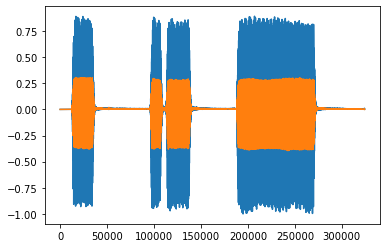

In [81]:
# Bin_Mix = convolution(sig_mono, HRIRs_array, ls_index, gains)
# sf.write('Binaural panning 2.wav',Bin_Mix,fs_s)
# plt.plot(Bin_Mix);
display(Audio(sig_mono, rate = fs_s))
current = convolution(sig_mono, HRIRs_array, ls_index, gains)
plt.plot(current);
Bin_Mix = current
print(current.shape)
# Bin_Mix = sum_signals([Bin_Mix[0], current[0]]) 
# display(Audio(Bin_Mix.T, rate = fs_s))
sf.write('Source18.wav',Bin_Mix,fs_s)


In [50]:
def sum_signals(signals):
    """
    Sum together a list of mono signals
    append zeros to match the longest array
    """
    if not signals:
        return np.array([])
    max_length = max(sig.shape[0] for sig in signals)
    left = np.zeros([max_length, 1])
    right = np.zeros([max_length, 1])
    for sig in signals:
        padded = np.zeros([max_length, 1])
        padded[0:sig.shape[0], 0] = sig[:,0]
        left += padded
        padded = np.zeros([max_length, 1])
        padded[0:sig.shape[0], 0] = sig[:,1]
        right += padded
        
    y = np.vstack([left,right]).transpose()
    y = y/np.max(np.abs(y))
    return y

In [ ]:
Audio(Bin_Mix.T, rate=fs_s)

In [ ]:
Bin_Mix = convolution(sig_mono, HRIRs_array, ls_index, gains)

In [ ]:
#Reference
import random
ele_ref = [45, 45, 45, 45, -45, -45, -45, -45]
azi_ref = [45, 135, 225, 315,45, 135, 225, 315]
for i in range(len(ele_ref)):
    ele = ele_ref[i]
    azi = azi_ref[i]
    print('Reference at: azimuth = ' + (str)(azi) + ', elevation = ' + (str)(ele))
    p_cart = ang_to_cart(azi, ele)
    gains, ls_index = find_active_triangles(p_cart, ls_vector, triangles)
    Bin_Mix = convolution(sig_mono, HRIRs_array, ls_index, gains)
    display(Audio(Bin_Mix.T, rate=fs_s))

In [ ]:
#Subject testing
import random
ele_set = []
azi_set = []
for i in range(10):
    ele = random.randint(-60, 60)
    azi = random.randint(0, 360)
    ele_set.append(ele)
    azi_set.append(azi)
    p_cart = ang_to_cart(azi, ele)
    gains, ls_index = find_active_triangles(p_cart, ls_vector, triangles)
    Bin_Mix = convolution(sig_mono, HRIRs_array, ls_index, gains)
    print('Test Example ' + (str)(i))
    display(Audio(Bin_Mix.T, rate=fs_s))

In [ ]:
#Show answer
print('Answers:')
for i in range(len(ele_set)):
    print((str)(i) + ': azimuth = ' + (str)(azi_set[i]) + ', elevation = ' + (str)(ele_set[i]))